<a href="https://colab.research.google.com/github/Redwoods/Py/blob/master/pdm2020/my-note/py-tensorflow/DL4-autoML/diabetes_autoML_df_df2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetes
- [dataset from kaggle](https://www.kaggle.com/himanshu86503/dibetes33hi)
## AutoML
- raw data
- imputed data

## 1. Importing Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## 2. Data Collection

In [ ]:
# Get the data from github
url = "https://github.com/Redwoods/Py/raw/master/pdm2020/my-note/py-pandas/data/diabetes.csv"
df = pd.read_csv(url)

In [ ]:
df.shape

(768, 9)

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
#  int or float ?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Cleaning data
- Check the NaN or missing values
- Clean the null data

In [ ]:
# Importing the dataset
# data = pd.read_csv('diabetes.csv')
#CHECK FOR NULL VALUES
df.isnull().values.any(), df.isna().sum()

(False,
 Pregnancies                 0
 Glucose                     0
 BloodPressure               0
 SkinThickness               0
 Insulin                     0
 BMI                         0
 DiabetesPedigreeFunction    0
 Age                         0
 Outcome                     0
 dtype: int64)

In [ ]:
# Drop unused columns, and drop rows with any missing values. (NOT neceaasry always!)
print(df.shape)
vars = df.columns
print(vars)
df = df[vars].dropna()
df.shape

(768, 9)
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


(768, 9)

## 3. Explore Data

### 위의 데이터에서 문제점을 찾으시오.
- 0이 허용되지 않는 특징이 있는가?
- 값 0을 어떤 값으로 변경해야하는가?

In [ ]:
# Check zeros in features without Outcome
(df.iloc[:,:8]==0).astype(int).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 60.0 KB


### Check the balance of the data through plot

C:\Users\life21c\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


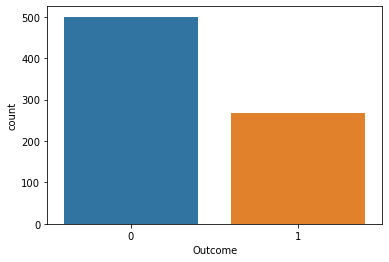

False: non-diabetes 500
True: diabetes 268


In [ ]:
# Check the balance of the data through plot
classes=df.Outcome
ax=sns.countplot(classes, label='count')
plt.show()
nDB,DB=classes.value_counts()
print('False: non-diabetes',nDB)
print('True: diabetes',DB)

In [ ]:
classes.value_counts(), type(classes) # noDM: 500, DM: 268

(0    500
 1    268
 Name: Outcome, dtype: int64,
 pandas.core.series.Series)

## correlation plot (상관도표)

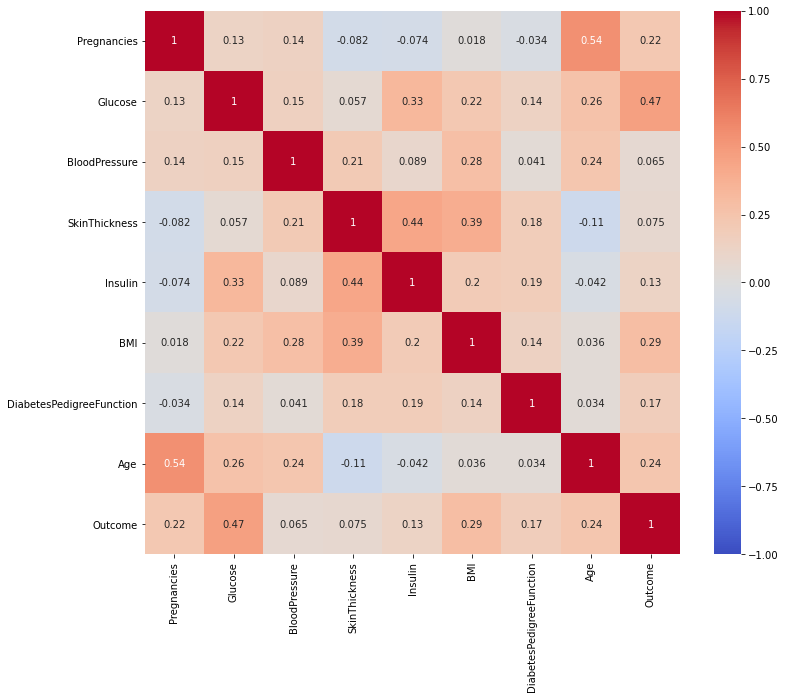

In [ ]:
#correlation plot
cormat=df.corr()
plt.figure(figsize=(12,10))
g=sns.heatmap(cormat, annot=True, cmap='coolwarm', #cmap= "RdYlGn",
             vmin=-1, vmax=1)

### 상관성 분석 결과
* Age vs. Pregnancies : 0.54
* Glucose vs. Outcome : 0.47
* SkinThickness vs. Insulin : 0.44
* SkinThickness vs. BMI : 0.39

> 좀 더 자세한 시각화가 필요하다.

---

## 각 특징의 내부 정보를 고려한 zero 처리 후 상관성 조사.

In [ ]:
# zero 처리 함수
# Clean the data : zero2median()
# 1. Check zeros in features with Pregnancies, Outcome excluded.
# 2. Replace zero with NaN 
# 3. Replace NaN with the median of the corresponding featurs
def zero2median(df):
    columns_with_zero = df.columns[(df==0).sum() > 0][1:-1]
    # Index(['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'], dtype='object')
    df[columns_with_zero]=df[columns_with_zero].replace(0,np.nan)
    for feature in columns_with_zero:
        df[feature].fillna(df[feature].median(),inplace=True)  # median() -> mean()
    
    return df

# Srart with cleaned dataframe
df2 = zero2median(df)
df2.shape

(768, 9)

In [ ]:
df2.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


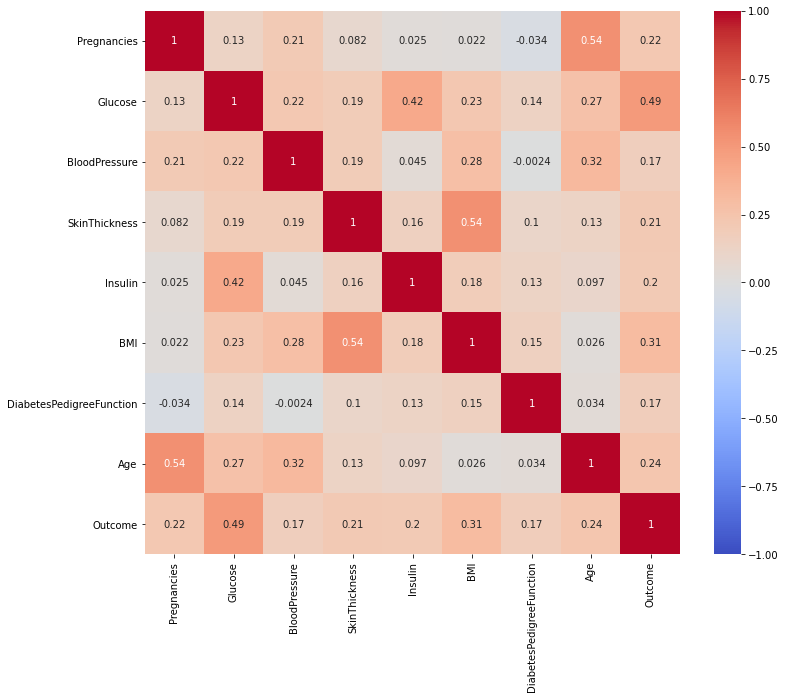

In [ ]:
#correlation plot of df2
# cormat2=df2.corr()
plt.figure(figsize=(12,10))
g3=sns.heatmap(df2.corr(),annot=True,cmap='coolwarm', #cmap= "RdYlGn",
             vmin=-1, vmax=1)

## 데이터프레임 df, df2의 상관성이 달라짐을 확인하시오.
### 상관성 분석 결과 
* Age vs. Pregnancies : 0.54 ->  0.54
* Glucose vs. Outcome : 0.47 ->  0.49
* SkinThickness vs. Insulin : 0.44 -> 0.16
* SkinThickness vs. BMI : 0.39 -> 0.54

> 상관성 최종 개선

---

### 그러면 다음 autoML에서는 어떤 데이터로 ML 모델을 만들어야하나요?

# AutoML
- ## pycaret
- ## data : df, df2

# targets
- ## 'noDM', 'DM'


In [ ]:
# !pip install pycaret

In [ ]:
# check version
from pycaret.utils import version
version()

'2.3.3'

In [ ]:
from pycaret.classification import *

## autoML using df

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


### Make data for pycaret autoML

In [ ]:
data = df.sample(frac=0.8, random_state=786)  # 8:2 split
data_unseen = df.drop(data.index).reset_index(drop=True)  # test data : 20%
data.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

Data for Modeling: (614, 9)
Unseen Data For Predictions (154, 9)


In [ ]:
clf = setup(data = data, target = 'Outcome', session_id=1104, 
                    normalize=True, 
                    transformation=True, 
                    ignore_low_variance=True,
        #    remove_multicollinearity=True, multicollinearity_threshold=0.95,
                    silent=True)

,Description,Value
0,session_id,1104
1,Target,Outcome
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(614, 9)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,1
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
best_model = compare_models(sort='Accuracy')
# compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7694,0.8222,0.5919,0.6979,0.6362,0.4704,0.4769,0.0140
rf,Random Forest Classifier,0.7601,0.8145,0.5443,0.6993,0.6098,0.4413,0.4498,0.0360
lr,Logistic Regression,0.7485,0.8164,0.5786,0.6581,0.6103,0.4274,0.4330,0.4790
ridge,Ridge Classifier,0.7415,0.0000,0.5581,0.6464,0.5920,0.4069,0.4133,0.0030
lda,Linear Discriminant Analysis,0.7415,0.8074,0.5648,0.6438,0.5942,0.4083,0.4148,0.0030
ada,Ada Boost Classifier,0.7413,0.7938,0.5771,0.6440,0.6061,0.4149,0.4181,0.0150
et,Extra Trees Classifier,0.7389,0.7938,0.4971,0.6660,0.5653,0.3862,0.3965,0.0340
knn,K Neighbors Classifier,0.7343,0.7877,0.5781,0.6289,0.6003,0.4025,0.4049,0.2320
lightgbm,Light Gradient Boosting Machine,0.7274,0.7884,0.5781,0.6145,0.5945,0.3899,0.3912,0.0810
svm,SVM - Linear Kernel,0.6854,0.0000,0.6376,0.5406,0.5741,0.3302,0.3444,0.0040


## Meaning of Prec., Recall,  F1, AUC
- Precision (Pres.) is an indication of how many positive
predictions are correct
- Recall identifies how many actual positive examples are correctly identified. 
> There is always a tradeoff between precision and recall so a new performance measuring parameter F1 score is introduced. 
- F1 score is a harmonic mean of precision and recall which gives a balance value between precision and recall.
- AUC is a measure of the area under the receiver operating characteristic curve.

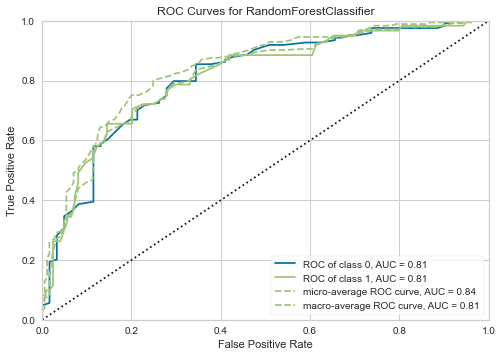

In [ ]:
current_model = 'rf'  # lightgbm
model = create_model(current_model, fold =10)
plot_model(model)

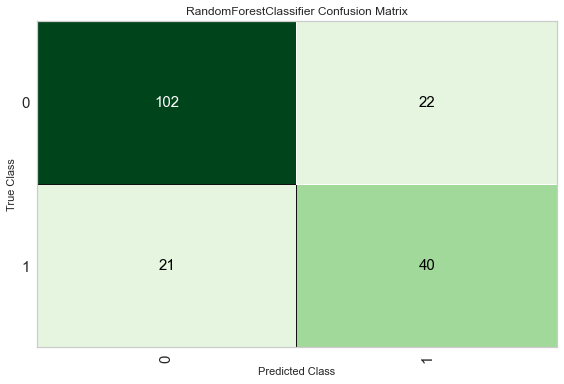

In [ ]:
plot_model(model, plot = 'confusion_matrix')

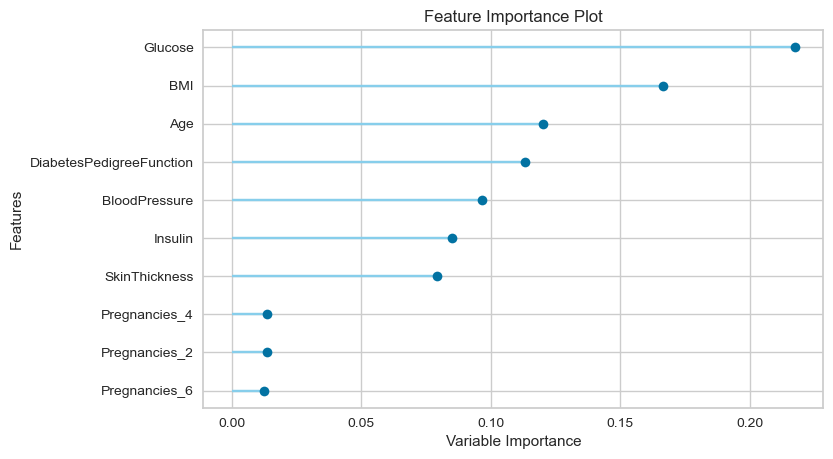

[0.21752048 0.09677328 0.07909828 0.08490756 0.16650726 0.11307153
 0.12017061 0.01113808 0.0116327  0.00515275 0.00290674 0.00375125
 0.0027948  0.00175427 0.00033543 0.01362823 0.00948444 0.01369691
 0.00755048 0.01255467 0.00643044 0.0096899  0.00944991]


In [ ]:
plot_model(model, plot = 'feature')
print(model.feature_importances_)

## SHAP
- https://eair.tistory.com/30?category=0

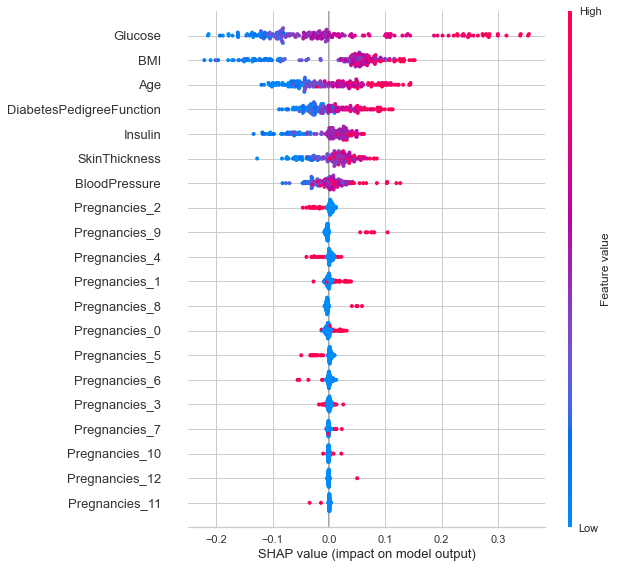

In [ ]:
# !pip install shap
interpret_model(model)  # Interpretability of the model

# Best model

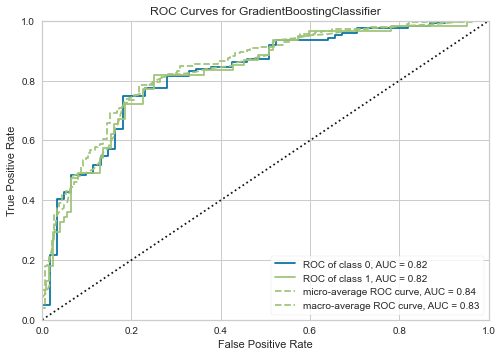

In [ ]:
plot_model(best_model)

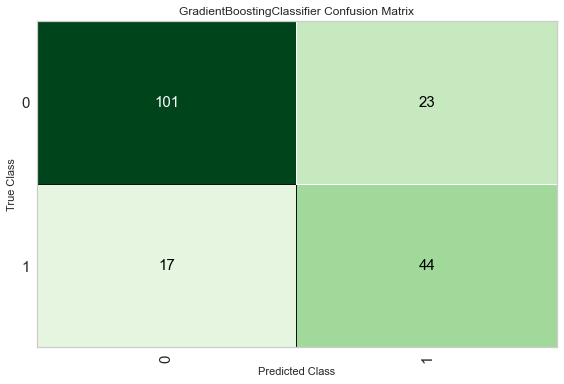

In [ ]:
# LABELS = ['noDM', 'DM']
plot_model(best_model, plot = 'confusion_matrix')

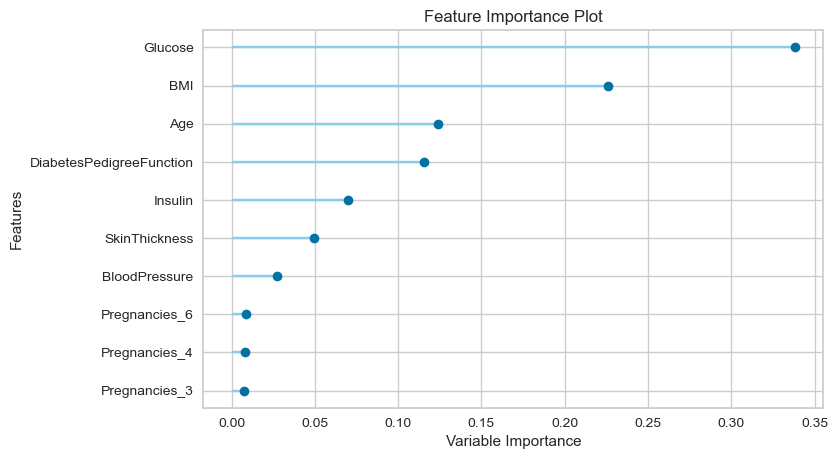

In [ ]:
plot_model(best_model, plot = 'feature')
# print(best_model.feature_importances_)

## SHAP - xAI
- https://eair.tistory.com/30?category=0
- tree를 이용한 ML 모델에 적용.

In [ ]:
# interpret_model(best_model)

## Pycaret - score
- 테스트 데이터에 적용하여 성능 평가.
- https://towardsdatascience.com/predict-lead-score-the-right-way-using-pycaret-332faa780cfc

In [ ]:
type(data_unseen),data_unseen.shape,data_unseen.head(3)

(pandas.core.frame.DataFrame,
 (154, 9),
    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
 0            1     89.0           66.0           23.0     94.0  28.1   
 1            5    116.0           74.0           29.0    125.0  25.6   
 2           10    115.0           72.0           29.0    125.0  35.3   
 
    DiabetesPedigreeFunction  Age  Outcome  
 0                     0.167   21        0  
 1                     0.201   30        0  
 2                     0.134   29        0  )

In [ ]:
# Predict test data
unseen_best_predictions = predict_model(best_model, data=data_unseen)
unseen_best_predictions

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Label,Score
0,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,0,0.9823
1,5,116.0,74.0,29.0,125.0,25.6,0.201,30,0,0,0.9004
2,10,115.0,72.0,29.0,125.0,35.3,0.134,29,0,1,0.5184
3,1,189.0,60.0,23.0,846.0,30.1,0.398,59,1,1,0.8978
4,5,166.0,72.0,19.0,175.0,25.8,0.587,51,1,1,0.7902
...,...,...,...,...,...,...,...,...,...,...,...
149,1,128.0,88.0,39.0,110.0,36.5,1.057,37,1,0,0.5344
150,1,106.0,76.0,29.0,125.0,37.5,0.197,26,0,0,0.8276
151,9,170.0,74.0,31.0,125.0,44.0,0.403,43,1,1,0.9924
152,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0,0,0.8748


In [ ]:
# unseen_predictions
from sklearn.metrics import accuracy_score
y_pred = list(unseen_best_predictions['Label'].values)
y_true = list(unseen_best_predictions['Outcome'].values)
best_accuracy = accuracy_score(y_true, y_pred)
print("Accuracy of the best model: {}".format(best_accuracy))


Accuracy of the best model: 0.7662337662337663


### 트레이닝 accuracy 76.9% -> **No overfitting**

In [ ]:
#confusion matrics
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[81 15]
 [21 37]]


## Summary of the best model

In [ ]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

---
---

## autoML using df2
- df2 : zero-preprocessed data

In [ ]:
df2.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


### 위에서 Pregnancies, Age가 categorical(정수) feature. -> 해결 방법은?

In [ ]:
# pycaret으로 학습할려면 특징값은 float
df2['Pregnancies'] = df['Pregnancies'].astype(float)
df2['Age'] = df['Age'].astype(float)
df2.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.0,125.0,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.0,125.0,26.6,0.351,31.0,0
2,8.0,183.0,64.0,29.0,125.0,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,1


In [ ]:
data = df2.sample(frac=0.8, random_state=786)  # 8:2 split
data_unseen = df2.drop(data.index).reset_index(drop=True)
data.reset_index(drop=True, inplace=True)

print('Using df2')
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions ' + str(data_unseen.shape))

Using df2
Data for Modeling: (614, 9)
Unseen Data For Predictions (154, 9)


In [ ]:
clf = setup(data = data, target = 'Outcome', session_id=1104, 
                    normalize=True, 
                    transformation=True, 
                    ignore_low_variance=True,
        #    remove_multicollinearity=True, multicollinearity_threshold=0.95,
                    silent=True)

,Description,Value
0,session_id,1104
1,Target,Outcome
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(614, 9)"
5,Missing Values,False
6,Numeric Features,8
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [ ]:
best_model2 = compare_models(sort='Accuracy')
# compare_models(sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7672,0.8183,0.6190,0.6852,0.6479,0.4752,0.4784,0.0250
lr,Logistic Regression,0.7555,0.8247,0.5648,0.6797,0.6119,0.4371,0.4442,0.0060
rf,Random Forest Classifier,0.7555,0.8009,0.5514,0.6869,0.6080,0.4344,0.4422,0.0570
ada,Ada Boost Classifier,0.7554,0.8029,0.5981,0.6648,0.6285,0.4473,0.4495,0.0220
ridge,Ridge Classifier,0.7485,0.0000,0.5648,0.6658,0.6052,0.4241,0.4310,0.0040
lda,Linear Discriminant Analysis,0.7462,0.8238,0.5648,0.6617,0.6031,0.4198,0.4268,0.0040
et,Extra Trees Classifier,0.7461,0.8067,0.5519,0.6607,0.5979,0.4158,0.4218,0.0560
qda,Quadratic Discriminant Analysis,0.7415,0.8032,0.6043,0.6387,0.6157,0.4224,0.4268,0.0040
nb,Naive Bayes,0.7368,0.8151,0.6519,0.6127,0.6284,0.4256,0.4289,0.0030
lightgbm,Light Gradient Boosting Machine,0.7297,0.7903,0.5848,0.6162,0.5966,0.3948,0.3974,0.0510


### Accuracy가 약간 높아졌지만 큰 차이는 없다.

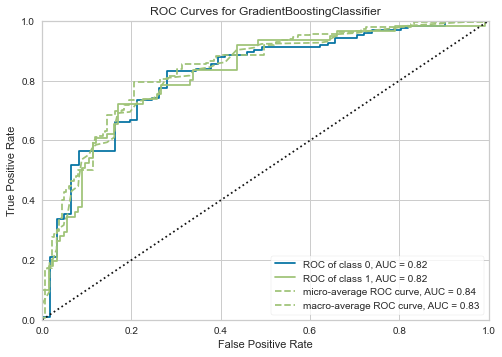

In [ ]:
plot_model(best_model2)

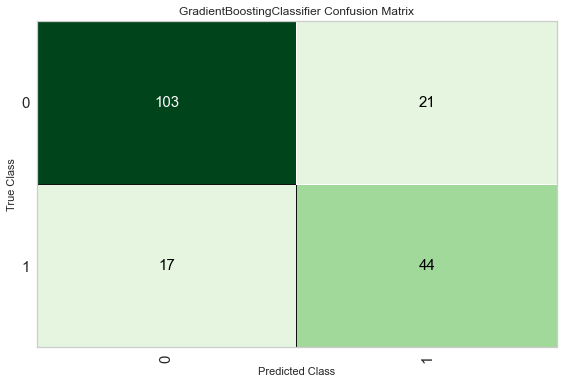

In [ ]:
plot_model(best_model2, 'confusion_matrix')

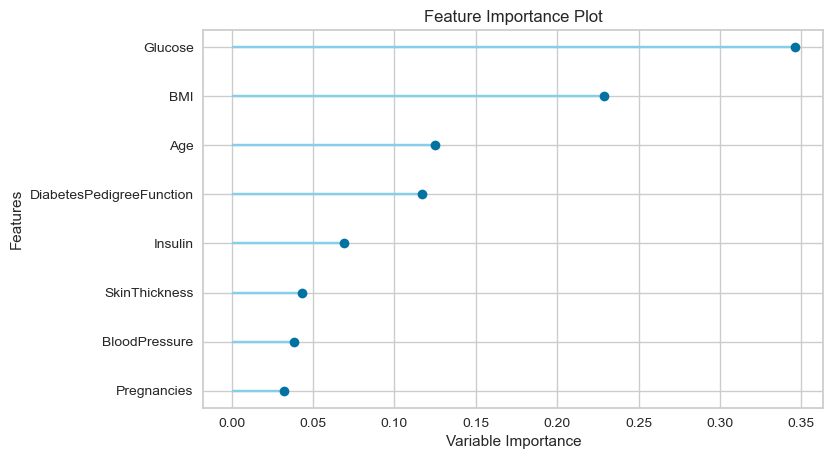

In [ ]:
plot_model(best_model2, plot = 'feature')

---
---

## [도전하기 - DIY]
- 최적의 모델을 찾아서 저장
    - save_model()
- 저장된 모델을 불러와서 테스트 데이터에 적용
    - load_model()
- 모델별로 accuracy를 표로 정리하시오.

---
---